# Expected Goals (xG)


This is a notebook that creates some simple xG models for the DataBallPy package. xG is a metric to evaluate the probability that a shot, given some characteristics of that shot, will turn out to be a goal. xG has been highly debated and discussed and is used increasingly in practice. There is a lot of information about expected goals, but if you want to read more, I highly recommend the blog posts from the KU Leuven:

- [How data availability influences xG models](https://dtai.cs.kuleuven.be/sports/blog/how-data-availability-affects-the-ability-to-learn-good-xg-models)
- [Illustrating the interplay between features and models in xG](https://dtai.cs.kuleuven.be/sports/blog/illustrating-the-interplay-between-features-and-models-in-xg)
- [How data quality affect xG performance](https://dtai.cs.kuleuven.be/sports/blog/how-data-quality-affects-xg)
- [Enhancing xG with freeze frame data](https://dtai.cs.kuleuven.be/sports/blog/enhancing-xg-models-with-freeze-frame-data)

Although we do have tracking data which provides us with the possibility to create a rather complex xG model, in this notebook we decided to keep things rather simple for two reasons: (1) The added performance xG models that use tracking data is low compared to xG models that do not use tracking data related features, and (2) keeping the model simple makes it easier to interpretet the model. Lets get started by importing some packages and the data!

```{warning}
Although we try to keep everything up to date, the code in this notebook might not perfectly align with the code in the package. If you find any bugs or have any suggestions, please let us know.
```

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss


from databallpy.features.angle import get_smallest_angle
from databallpy.visualize import plot_soccer_pitch

In [7]:
data = pd.read_csv("../../data/shot_features.csv", index_col="Unnamed: 0")

```{note}
This is a private dataset and cannot be shared. If you want to run this notebook, you need to have access to your own data. The data is just a set of shots with some characteristics. These can be directly obtained from a game (`game.shots_df`). Make sure to normalize the direction of play for easier processing. In this dataset all shots are taken on the goal on the right side (53.0, 0.0).
```

## Data preprocessing

In the data processing we will do the following steps:

1. Delete shots where the distance is larger than 53 meters since these shots are not realistic and probably errors in the event data.

2. Create a binary column to indicate whether the shot was taken by foot.

3. Remove unnecessary columns.

4. Creating a binary column to indicate whether the shot was a goal.

In [8]:
data = data[data["ball_goal_distance"] <= 53].copy()

data["is_by_foot"] = data["body_part"].apply(lambda x: 1 if "foot" in x else 0)
data.drop(columns=["body_part"], inplace=True)

data = data[["ball_goal_distance", "shot_angle", "is_by_foot", "type_of_play", "shot_outcome"]].copy()

data["shot_outcome"] = data["shot_outcome"].apply(lambda x: 1 if x=="goal" else 0)

print(data["shot_outcome"].value_counts())
print(data.info())
print(data.describe())

shot_outcome
0    14138
1     1706
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 15844 entries, 0 to 41
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ball_goal_distance  15844 non-null  float64
 1   shot_angle          15844 non-null  float64
 2   is_by_foot          15844 non-null  int64  
 3   type_of_play        15844 non-null  object 
 4   shot_outcome        15844 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 742.7+ KB
None
       ball_goal_distance    shot_angle    is_by_foot  shot_outcome
count        15844.000000  15844.000000  15844.000000  15844.000000
mean            17.069520     26.114796      0.819111      0.107675
std              7.794867     16.745407      0.384938      0.309979
min              0.600167      0.022857      0.000000      0.000000
25%             10.637804     15.295443      1.000000      0.000000
50%             16.

Looking at the data, we have a total of 15844 shots, of which 1706 are actual goals (10.8%). Our baseline model would just assume that every shot has a 10.8% chance of being a goal, but I think we can do better. The next step is creating different datasets for different types of shots. In open play, you either shoot by foot, or with an header (roughly speaking). Second, we also have set pieces. For penalties, we know that all features (distance to goal and shot angle) are equal, so the xG of a penalty is just the success rate of all penalties in our dataset. For free kicks, the distance and goal angle is variable, therefore we will also create a model for free kicks specifically. Last, we will create a xG for all shots, to evaluate if the different types of shots actually are different in terms of xG or not.


In [9]:
open_play_data = data[data["type_of_play"].isin(["regular_play", "corner_kick", "crossed_free_kick", "counter_attack"])]
free_kick_data = data[data["type_of_play"]=="free_kick"]
penalty_data = data[data["type_of_play"]=="penalty"]
foot_data = open_play_data[open_play_data["is_by_foot"] == 1]
header_data = open_play_data[open_play_data["is_by_foot"] == 0]

all_datasets = [foot_data, header_data, free_kick_data]
all_shots = pd.concat(all_datasets)
all_datasets.append(all_shots)

titles = ["shots by foot", "shots by header", "shots by free kick", "shots from all situations combined"]
print(f"The xG of a penalty in our dataset is {round(len(penalty_data[penalty_data['shot_outcome']==1]) / len(penalty_data), 3)}\n")

for data, title in zip (all_datasets, titles):
    n_goals = len(data[data["shot_outcome"]==1])
    print(f"We have {len(data)} {title}, of which {n_goals} is a goal ({round(n_goals*100/len(data), 1)}%).")

The xG of a penalty in our dataset is 0.792

We have 12322 shots by foot, of which 1281 is a goal (10.4%).
We have 2866 shots by header, of which 302 is a goal (10.5%).
We have 536 shots by free kick, of which 28 is a goal (5.2%).
We have 15724 shots from all situations combined, of which 1611 is a goal (10.2%).


The percentage goals for the in play subsets seems to be relatively stable. For the free kicks here is a lower percentage of goals scored. Also note that the total shots and goals has decreased slightly since we excluded the penalties. However, this is still very describtive, lets look at the relation between the features and the goals scored.

## Creating the Features

We will mainly use two features to create the xG model:

1. The shot distance

2. The shot angle

Before really going into the data exploration, it is good to talk about what the features actually mean. The distance is the distance of the ball till the center of the goal in meters. The angle is the angle between two vectors: (1) the vector between the shot location and the right post, and (2) the vector between the shot location and the left post. The shot angle is therefore a function of the distance to the goal and the angle with the goal. For instance, the shot angle for shot 1 and 2 are almost equal, but shot 1 is closer to the goal, however, it is also moved out to the side more. Shot 3 and 4 are perfectly aligned between each other, but shot 4 has an angle of 4 degrees and shot 3 of 13 degrees. This is of course because the distance to the goal is a lot higher for shot 4 compared to shot 3. 

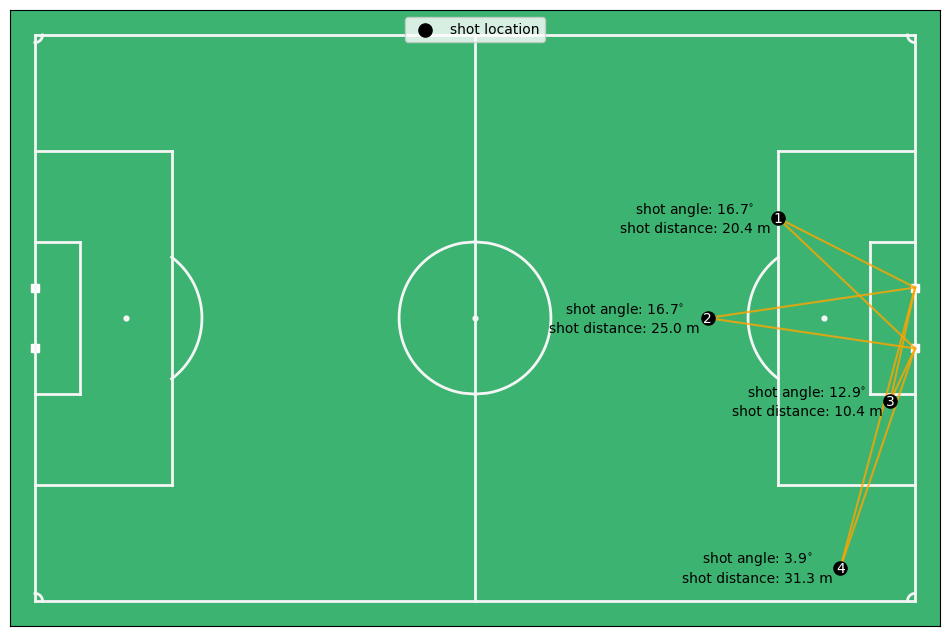

In [10]:
def get_shot_angle(x:float, y:float) -> float:
    """Given a x, y coordinate, calculates the angle in degrees between 
    the vector from the ball to the left post and the vector form the ball 
    to the right post."""
    
    ball_xy = np.array([x, y])
    left_post_xy = np.array([53, 3.66])
    right_post_xy = np.array([53, -3.66])
    
    ball_left_post_vector = left_post_xy - ball_xy
    ball_right_post_vector = right_post_xy - ball_xy
    
    angle = get_smallest_angle(
            ball_left_post_vector, ball_right_post_vector, angle_format="degree"
    )
    return angle

left_post_xy = np.array([53, 3.66])
right_post_xy = np.array([53, -3.66])

x_locs = [53-16.5, 52-24, 53-3, 53-9]
y_locs = [12, 0, -10, -30]
fig, ax = plot_soccer_pitch()
ax.scatter(x_locs, y_locs, label="shot location", color="black", s=90)
n = 1
for x, y in zip(x_locs, y_locs):
    ax.plot([x, left_post_xy[0]], [y, left_post_xy[1]], color="orange", alpha=0.8, zorder=-.05)
    ax.plot([x, right_post_xy[0]], [y, right_post_xy[1]], color="orange", alpha=0.8, zorder=-.05)
    ax.text(x, y-0.15, str(n), color="white", fontsize=10, ha="center", va="center")
    n += 1
    shot_angle = get_shot_angle(x, y)
    distance = np.sqrt((x-53)**2 + y**2)

    angle_text = f"shot angle: ${shot_angle:.1f}^{{\\circ}}$"
    distance_text = f"shot distance: {distance:.1f} m"
    ax.text(x-10, y + 1, angle_text, color="black", fontsize=10, ha="center", va="center")
    ax.text(x-10, y - 1.3, distance_text, color="black", fontsize=10, ha="center", va="center")

ax.legend(loc= "upper center")
plt.show()
    


## Data Exploration

Now that you have a feel for the features we use, lets look at how they relate with goal scoring probabilities. 

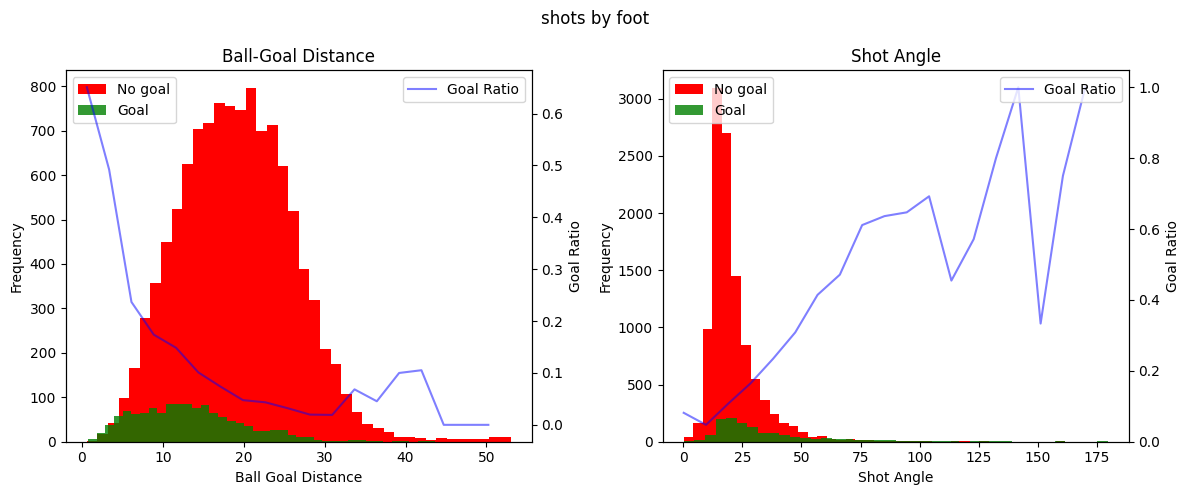

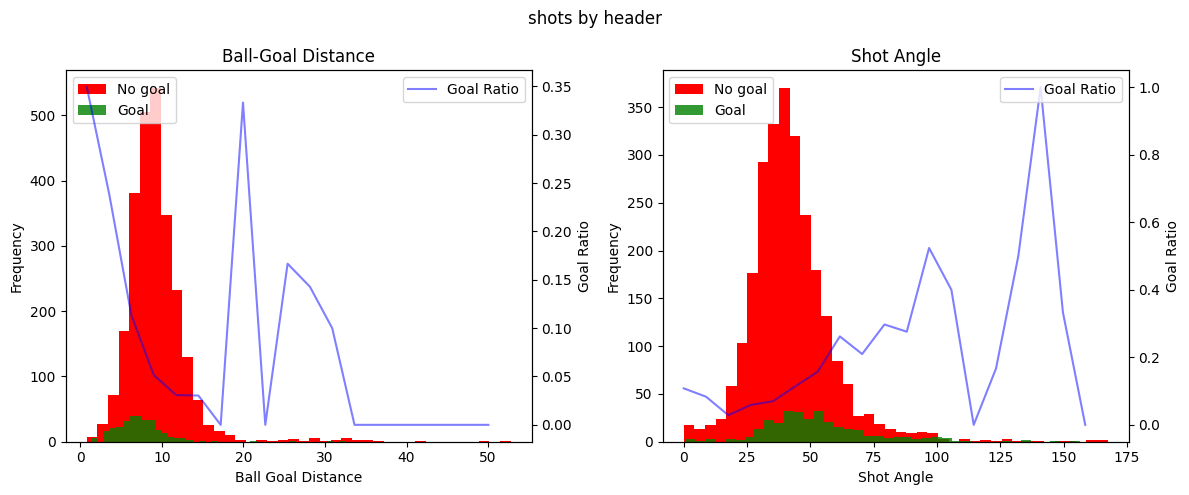

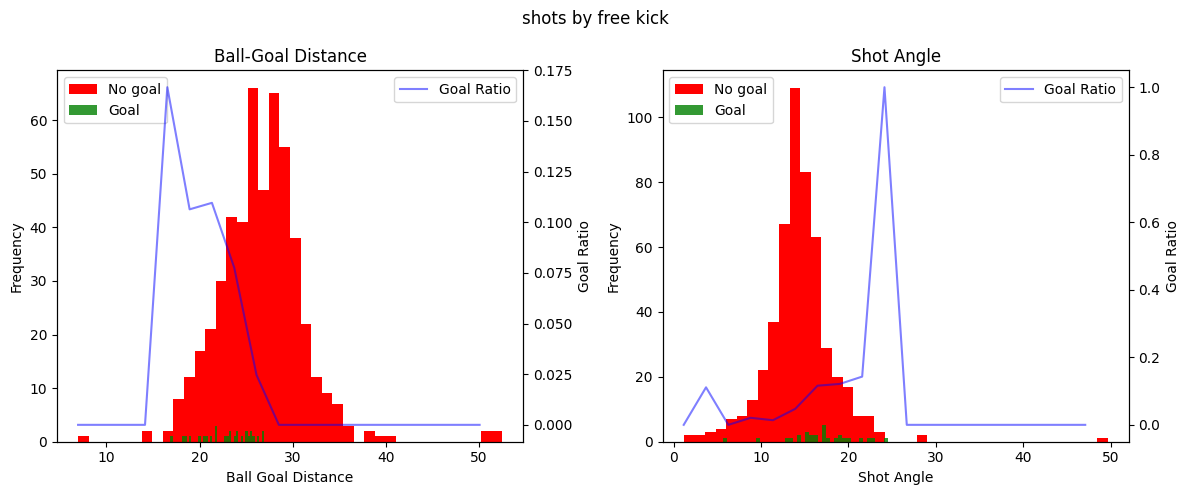

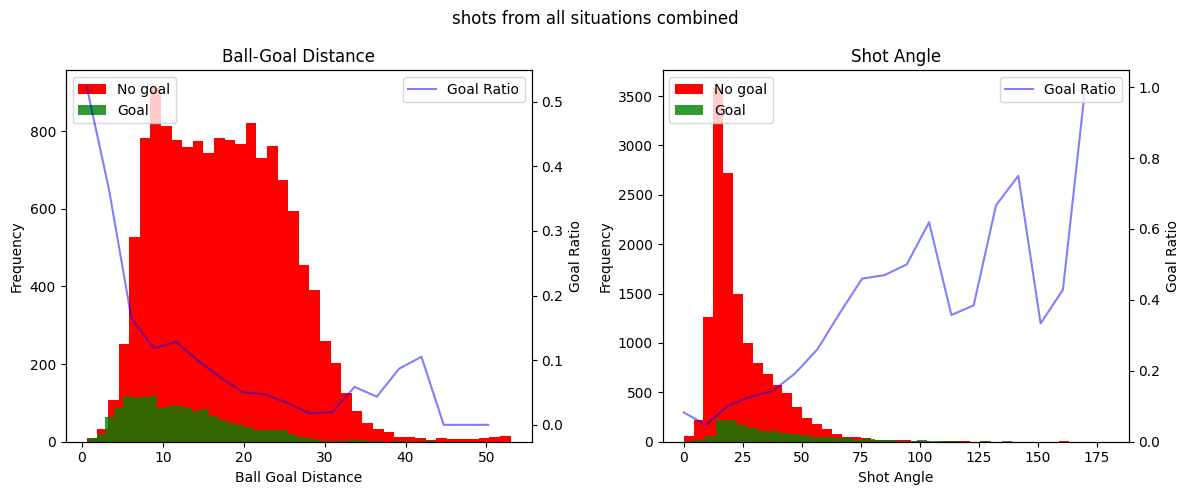

In [11]:
def plot_metric(data, metric, ax, title):

    bins = np.linspace(data[metric].min(), data[metric].max(), 20)
    hist_goals = np.histogram(data.loc[data["shot_outcome"]==1, metric], bins=bins)[0]
    hist_total = np.clip(np.histogram(data[metric], bins=bins)[0], a_min=1e-5, a_max=None)
    percentage_goals = hist_goals / hist_total
    
    ax.hist(data.loc[data["shot_outcome"]==0, metric], bins=40, color="red", label="No goal")
    ax.hist(data.loc[data["shot_outcome"]==1, metric], bins=40, color="green", alpha=0.8, label="Goal")
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.legend(loc="upper left")
    
    ax2 = ax.twinx()
    ax2.plot(bins[:-1], percentage_goals, color="blue", label="Goal Ratio", alpha=0.5)
    ax2.set_ylabel("Goal Ratio")
    ax2.legend(loc="upper right")
    
    ax.set_title(title)

for data, title in zip(all_datasets, titles):
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 5))
    
    plot_metric(data, "ball_goal_distance", ax1, 'Ball-Goal Distance')
    plot_metric(data, "shot_angle", ax3, 'Shot Angle')
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

This is very interesting! We can clearly see a few things. Firstly, the shot distance seem to exponentionally decrease the ratio of shots being scored as the distance from the shot to the goal increases. Secondly, there seems to be a linear increase in the ratio of shots being scored with the increase of the shot angle. It seems that these variables do indeed hold information about whether a shot is going to be a goal or not. You can also clearly see that the goal ratio values become more and more random as we have less samples, for instance when shots are taken from more than 30 meters or in general in the free kick data. 

## Building the xG models

We will build the expected goal models for every type of shot. For this we will simply use a logistic regression since it is easiest to interpret.

In [12]:
models = {}
scalers = {}
random_state = 42

for data, title in zip(all_datasets, titles):
    y = data["shot_outcome"].copy().astype("category")
    X = data[["ball_goal_distance", "shot_angle"]].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train.values)
    scalers[title] = scaler
    
    logistic_reg = LogisticRegression(solver="liblinear")
    logistic_reg.fit(X_scaled, y_train)
    models[title] = logistic_reg

    X_test_scaled = scaler.transform(X_test.values)
    y_pred_proba = logistic_reg.predict_proba(X_test_scaled)[:, 1]
    
    brier_loss = round(brier_score_loss(y_test, y_pred_proba), 3)
    beta_values = logistic_reg.coef_[0]
    print(f"For the {title}: Brier Score Loss: {brier_loss}")
    for i, col in enumerate(["shot distance", "shot angle"]):
        print(f"\t{col} beta: {round(beta_values[i], 3)}")


For the shots by foot: Brier Score Loss: 0.083
	shot distance beta: -0.611
	shot angle beta: 0.317
For the shots by header: Brier Score Loss: 0.09
	shot distance beta: -0.579
	shot angle beta: 0.215
For the shots by free kick: Brier Score Loss: 0.057
	shot distance beta: -0.816
	shot angle beta: 0.083
For the shots from all situations combined: Brier Score Loss: 0.086
	shot distance beta: -0.441
	shot angle beta: 0.319


### Inspecting the models

Looking at the Brier score losses, we see that the models have definately trained pretty good. With more data, more complex models and more complex features we could do better, but for the simplest possible model, I am happy with these initial results. The Brier score indicates that the free kick model was best fitted, even though we now that model had the least data. This is probably because the ratio of free kicks being scored was very low (5%). Therefore the model can perform really well by guessing every shot is no goal, let's hope, that is not what the model learned.

Taking it a step further, we can look at the beta values. Personally, I would expect negative beta values for the distance feature (greater distance makes it harder to score) and postive values of the shot angle feature (greater shot angle means you are either closer or more in front of the goal, making it easier to score).

Looking at the results we see that indeed the distance beta value is negative for all models, with values between -0.82 and -0.44. This shows that a greater distance is decreasing the chance of scoring more for free kicks than for regular play shots by foot and headers. The beta angle values are all positive, also as expected. Looking at the beta values we can see that in all models the distance variable was the most important in predicting whether a shot will be a goal.

Lets look at some visualizations to confirm that the model predicts intuitive xG values.

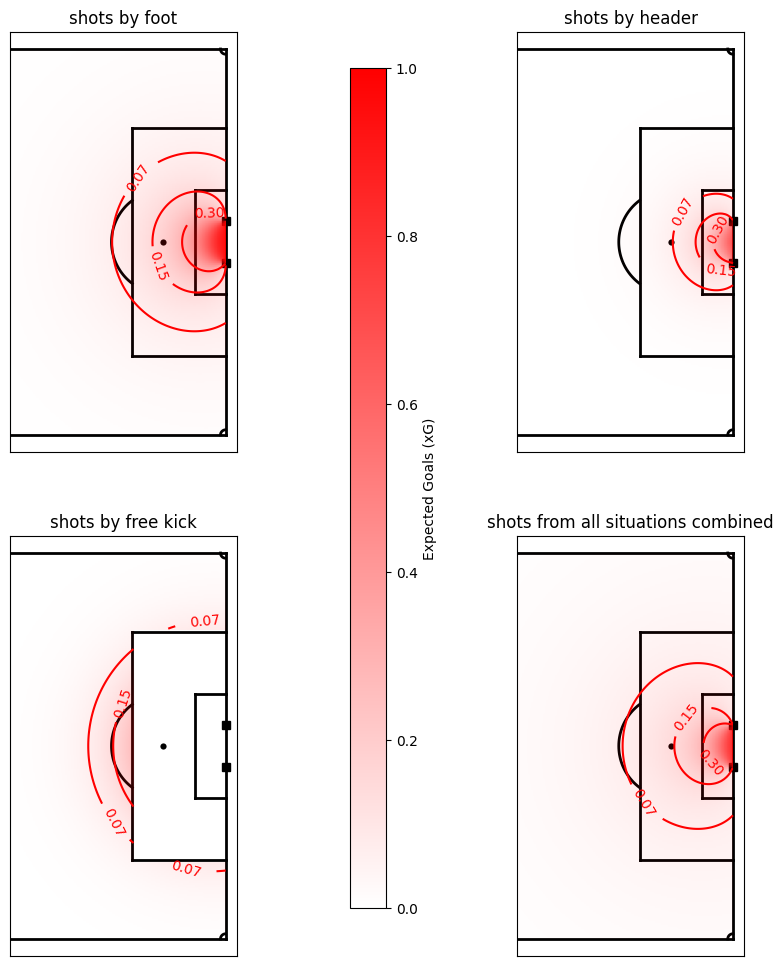

In [13]:
x_range = np.linspace(0, 53, 200)  
y_range = np.linspace(-34, 34, 200)   
x, y = np.meshgrid(x_range, y_range)
goal_x, goal_y = 53, 0
distance = np.sqrt((x - goal_x) ** 2 + (y - goal_y) ** 2)
angle = np.vectorize(get_shot_angle)(x, y)

colors = [(1, 0, 0, alpha) for alpha in np.linspace(0.001, 1.0, 256)]
custom_cmap = LinearSegmentedColormap.from_list('custom_red', colors)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
pitch_axes = []
for ax in axes.ravel():
    fig, ax = plot_soccer_pitch(pitch_color="white", ax=ax, fig=fig)
    pitch_axes.append(ax)
    

for title, ax in zip(titles, pitch_axes):
    X_heatmap = np.column_stack((distance.ravel(), angle.ravel()))
    scaler = scalers[title]
    X_heatmap_preprocessed = scaler.transform(X_heatmap)  
    model = models[title]
    xG_values = model.predict_proba(X_heatmap_preprocessed)[:, 1]
    xG_matrix = xG_values.reshape(x.shape)

    if title == "shots by free kick":
        mask = (np.abs(y) < 20.5) & (x > 37)
        xG_matrix[mask] = np.nan
    
    # fig, ax = plot_soccer_pitch(pitch_color="white")
    # ax.set_xlim(20, 55)
    im = ax.imshow(xG_matrix, extent=[0, 53, -34, 34], origin='lower', cmap=custom_cmap, vmin=0, vmax=1)
    contour = ax.contour(x, y, xG_matrix, colors='red', levels=[0.07, 0.15, 0.3], linestyles='solid')
    ax.clabel(contour, inline=True, fontsize=10)

    ax.set_title(title)
    ax.set_xlim(15, 55)
    ax.set_aspect("equal")

cbar_ax = fig.add_axes([0.49, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax) 
cbar.set_label('Expected Goals (xG)')
plt.show()

The xG model for the shots by foot in regular play and of all shots are pretty similar. This is because most shots in our dataset were shots by foot in regular play. You can also clearly see that the distance component is more limiting for the headers than for the shots. On top of that, it is interesting to see that free kicks from just outside the box have a twice as high probability of being a goal than regular shots do, so shooting from that distance out of a free kick can be justified. Over all, we can see that creating xG models for different types of shots seems to be better than one single xG model for all shots.

# xG in DataBallPy

To get the the xG values in DataBallPy you need to have a look at the `game.shots_df`. Since the xG model only uses the location of the shot, the xG is calculated for every shot.

````{margin}
```{note}
Since the `"synced_game"` only includes the first 6 minutes of the game, it only includes 1 shot here.
```
````

```python
from databallpy import get_game, get_open_game

game = get_game(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open game provided by DFL/Sportec Solutions
game = get_open_game()
```

```{note}
Please see [Loading in a game](https://databallpy.readthedocs.io/en/latest/getting_started/loading_in_a_game_page.html) for extra information and the supported providers
```

In [36]:
from databallpy import get_saved_game
import os

game_synced = get_saved_game("synced_game", os.path.join("..", "saved_games"))
game_not_synced = get_saved_game("not_synced_game", os.path.join("..", "saved_games"))
for shot in game_synced.shot_events.values():
    frame = game_synced.tracking_data[game_synced.tracking_data["event_id"]==shot.event_id]
    shot._update_ball_goal_distance(frame[["ball_x", "ball_y"]].values[0]+ 2)
    shot._update_shot_angle(frame[["ball_x", "ball_y"]].values[0]+ 2)
    shot.xg = shot.get_xg()
    break

In [37]:
print(game_synced.shots_df["xg"].iloc[0])
print(game_not_synced.shots_df["xg"].iloc[0])

0.12133992566974895
0.10110023799307004


````{note}
As you can see, the values are slightly different. For the synced game, you can run `game.add_tracking_data_features_to_shots()`. This updates the location of the event based on tracking data. Therefore, also the xG value changes. For the non synced game, this information is not known, and therefore the x and y location of the event data is used.

To get the xG values based on the tracking data ball location:
```python
# assuming you have loaded in a game object called `game`
game.synchronise_tracking_and_event_data()
game.add_tracking_data_features_to_shots()

print(game.shots_df["xG"].iloc[0])
```
````

In [16]:
import json

save_dir = "../databallpy/models"

final_json = {
    "xg_by_foot":{"standard_scaler": {"mean": {"dist": np.nan, "angle": np.nan}, "var": {"dist": np.nan, "angle": np.nan}}, "logreg": {"coefs": {"dist": np.nan, "angle":np.nan}, "intercept": np.nan}}, 
    "xg_by_head":{"standard_scaler": {"mean": {"dist": np.nan, "angle": np.nan}, "var": {"dist": np.nan, "angle": np.nan}}, "logreg": {"coefs": {"dist": np.nan, "angle":np.nan}, "intercept": np.nan}}, 
    "xg_by_free_kick":{"standard_scaler": {"mean": {"dist": np.nan, "angle": np.nan}, "var": {"dist": np.nan, "angle": np.nan}}, "logreg": {"coefs": {"dist": np.nan, "angle":np.nan}, "intercept": np.nan}}, 

}
for title, save_name in zip(titles[:-1], final_json.keys()):
    scaler = scalers[title]
    final_json[save_name]["standard_scaler"]["mean"]["dist"] = scaler.mean_[0]
    final_json[save_name]["standard_scaler"]["mean"]["angle"] = scaler.mean_[1]
    final_json[save_name]["standard_scaler"]["var"]["dist"] = scaler.var_[0]
    final_json[save_name]["standard_scaler"]["var"]["angle"] = scaler.var_[1]
    model = models[title]
    final_json[save_name]["logreg"]["coefs"]["dist"] = model.coef_[0, 0]
    final_json[save_name]["logreg"]["coefs"]["angle"] = model.coef_[0, 1]
    final_json[save_name]["logreg"]["intercept"] = model.intercept_[0]

with open(save_dir + "/xg_params.json", "w") as file:
    json.dump(final_json, file)


FileNotFoundError: [Errno 2] No such file or directory: '../databallpy/models/xg_params.json'

In [85]:
# shortly check if saving the models went right
save_dir = "../databallpy/models"
distance = 16 # meters
angle = np.rad2deg(np.arctan2(3.66, 16) * 2) # directly in front of the goal

for title, model in final_json.items():
    print(title)
    scaled_dist = (distance - model["standard_scaler"]["mean"]["dist"]) / np.sqrt(model["standard_scaler"]["var"]["dist"])
    scaled_angle = (angle - model["standard_scaler"]["mean"]["angle"]) / np.sqrt(model["standard_scaler"]["var"]["angle"])

    coefs_dist = model["logreg"]["coefs"]["dist"]
    coefs_angle = model["logreg"]["coefs"]["angle"]
    intercept = model["logreg"]["intercept"]
    
    linear = np.dot([scaled_dist, scaled_angle], [coefs_dist, coefs_angle]) + intercept
    xg = 1 / (1 + np.exp(-linear))
    print("\t", xg)

xG_by_foot
	 0.10592312601173245
xG_by_head
	 0.027729179049142842
xG_by_free_kick
	 0.2770389597953205


# Conclusion

In this notebook we created some simple xG models for different types of shots. We saw that the distance to the goal is the most important feature in predicting whether a shot will be a goal or not. We also saw that the models for different types of shots are different, which is why it is important to create different models for different types of shots. We also saw that the models performed well, with Brier scores of around 0.1. This is a good start, but we can do better. In the future, we can look at more complex models and features, and also look at how we can use tracking data to improve our xG models.